In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
results2015 = pd.read_csv('../brexit/hocl-ge2015-results-summary.csv')
for party in ['lab','con','ld','green','snp','pc','ukip','dup','sf','sdlp','uup','alliance','other']:
    results2015[party+'_pc'] = 100*results2015[party] / results2015.valid_votes
mapping2015 = pd.read_csv('../brexit/LAD12_PCON12_UK_LU.csv')
mapping2015['ons_id'] = mapping2015['PCON12CD']
print len(results2015)
results2015 = pd.merge(results2015, mapping2015, on='ons_id',how='left').drop_duplicates('PCON12NM')
print len(results2015)
results2015['turnout2015'] = results2015.valid_votes / results2015.electorate
results2015['majoritypct2015'] = results2015.majority / results2015.valid_votes
results2015['invalidpct2015'] = results2015.invalid_votes / results2015.electorate

650
650


Index([u'id', u'Region_Code', u'Region', u'Area_Code', u'Area', u'Electorate',
       u'ExpectedBallots', u'VerifiedBallotPapers', u'Pct_Turnout',
       u'Votes_Cast', u'Valid_Votes', u'Remain', u'Leave', u'Rejected_Ballots',
       u'No_official_mark', u'Voting_for_both_answers', u'Writing_or_mark',
       u'Unmarked_or_void', u'Pct_Remain', u'Pct_Leave', u'Pct_Rejected',
       u'ons_id', u'ons_region_id', u'constituency_name', u'county_name',
       u'region_name', u'country_name', u'constituency_type',
       u'declaration_time', u'result', u'first_party', u'second_party',
       u'electorate', u'valid_votes', u'invalid_votes', u'majority', u'con',
       u'lab', u'ld', u'ukip', u'green', u'snp', u'pc', u'dup', u'sf', u'sdlp',
       u'uup', u'alliance', u'other', u'lab_pc', u'con_pc', u'ld_pc',
       u'green_pc', u'snp_pc', u'pc_pc', u'ukip_pc', u'dup_pc', u'sf_pc',
       u'sdlp_pc', u'uup_pc', u'alliance_pc', u'other_pc', u'LAD12CD',
       u'LAD12CDO', u'LAD12NM', u'PCON12CD'

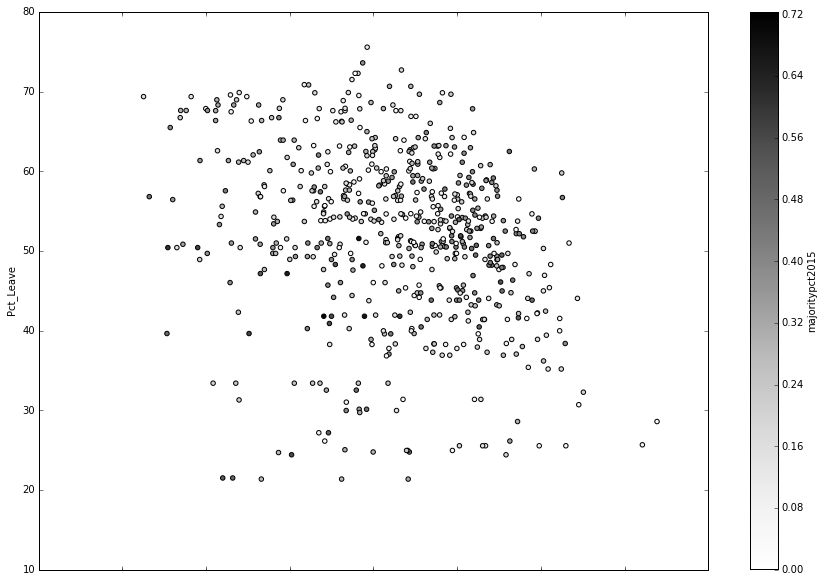

In [127]:
ref2016 = pd.read_csv('../brexit/EU-referendum-result-data.csv')
ref2016 = pd.merge(ref2016,results2015,left_on='Area_Code',right_on='LAD12CD',how='inner')
print ref2016.columns
print len(ref2016)
print 'Leave pct correlation with 2015 party pcts:'
for party in ['lab','con','ld','green','snp','pc','ukip','other']:
    print '%s: %.2f' % (party,ref2016.Pct_Leave.corr(ref2016[party+'_pc']))
print '\nAnd with other fields:'
for field in ['turnout2015','majoritypct2015','invalidpct2015']:
    print '%s: %.2f' % (field,ref2016.Pct_Leave.corr(ref2016[field]))
ref2016.plot.scatter(x='turnout2015',y='Pct_Leave',c='majoritypct2015',figsize=(15,10))

In [137]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, LassoCV
from sklearn import cross_validation,metrics

(435, 73) (187,)
LM MAE:  8.62483712141 , Ridge MAE:  8.62483527326 , LassoCV MAE:  8.62483527326
LM MAE:  8.66986363878 , Ridge MAE:  8.66985832758 , LassoCV MAE:  8.66985832758
LM MAE:  8.77610302272 , Ridge MAE:  8.77608107317 , LassoCV MAE:  8.77608107317
LM MAE:  7.60525722029 , Ridge MAE:  8.05407364921 , LassoCV MAE:  8.05407364921
LM MAE:  7.47412887948 , Ridge MAE:  7.95351115665 , LassoCV MAE:  7.95351115665
LM MAE:  7.48376405183 , Ridge MAE:  7.95351098351 , LassoCV MAE:  7.95351098351
LM MAE:  5.12719969883 , Ridge MAE:  5.10492900887 , LassoCV MAE:  5.10492900887
LM MAE:  4.85621833472 , Ridge MAE:  4.82851880355 , LassoCV MAE:  4.82851880355


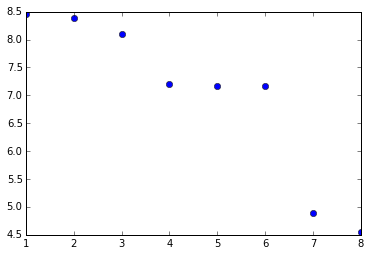

In [139]:
#TODO: simple predictive model for leave pct using 2015 party pcts
#  May want interaction between turnout and majority?
model1 = LinearRegression()
model2 = Ridge()
model3 = LassoCV()

X_train, X_test, y_train, y_test = cross_validation.train_test_split(ref2016, ref2016['Pct_Leave'], test_size=0.3)
print X_train.shape, y_test.shape

predictors = ['ld_pc','lab_pc','con_pc','turnout2015','majoritypct2015','invalidpct2015','ukip_pc','green_pc']
r2s, maes = [], []
for i in range(1,len(predictors)+1):
    model1.fit(X_train[predictors[:i]], y_train)
    r2s.append(np.corrcoef(y_test, model1.predict(X_test[predictors[:i]]))[0,1])
    maes.append(metrics.mean_absolute_error(y_test,model1.predict(X_test[predictors[:i]])))
    model2.fit(X_train[predictors[:i]], y_train)
    model3.fit(X_train[predictors[:i]], y_train)
    print 'LM MAE: ',-1*cross_validation.cross_val_score(model1, ref2016[predictors[:i]], ref2016['Pct_Leave'], cv=10, scoring='mean_absolute_error').mean(),\
        ', Ridge MAE: ',-1*cross_validation.cross_val_score(model2, ref2016[predictors[:i]], ref2016['Pct_Leave'], cv=10, scoring='mean_absolute_error').mean(),\
        ', LassoCV MAE: ',-1*cross_validation.cross_val_score(model2, ref2016[predictors[:i]], ref2016['Pct_Leave'], cv=10, scoring='mean_absolute_error').mean()

#plt.plot(list(y_test), model1.predict(X_test[predictors]), 'o')
plt.plot(range(1,len(predictors)+1), maes, 'o')
#print cross_validation.cross_val_score(model1, ref2016[predictors], ref2016['Pct_Leave'], cv=10, scoring='mean_absolute_error')

In [172]:
#add categorical variable - city/country
ref2016['isBorough'] = ref2016.constituency_type=='Borough'
ref2016['isCounty'] = ref2016.constituency_type=='County'
ref2016['toriesFirst'] = ref2016.first_party=='Con'
ref2016['snpFirst'] = ref2016.first_party=='SNP'
print ref2016.groupby('toriesFirst').Pct_Leave.mean()
print ref2016.groupby('snpFirst').Pct_Leave.mean()
for field in ['isBorough','isCounty','toriesFirst','snpFirst']:
    ref2016[field] = pd.Categorical(ref2016[field]).codes

X_train, X_test, y_train, y_test = cross_validation.train_test_split(ref2016, ref2016['Pct_Leave'], test_size=0.3)

model2.fit(X_train[predictors], y_train)
print metrics.mean_absolute_error(y_test,model2.predict(X_test[predictors]))
model2.fit(X_train[predictors+['isBorough']], y_train)
print metrics.mean_absolute_error(y_test,model2.predict(X_test[predictors+['isBorough']]))
model2.fit(X_train[predictors+['isBorough','toriesFirst']], y_train)
print metrics.mean_absolute_error(y_test,model2.predict(X_test[predictors+['isBorough','toriesFirst']]))
model2.fit(X_train[predictors+['isBorough','toriesFirst','snpFirst']], y_train)
print metrics.mean_absolute_error(y_test,model2.predict(X_test[predictors+['isBorough','toriesFirst','snpFirst']]))


for i in range(len(predictors+['isBorough','toriesFirst','snpFirst'])):
    print '%s: %.3f' % (list(predictors+['isBorough','toriesFirst','snpFirst'])[i],model2.coef_[i])

toriesFirst
False    49.302290
True     54.640862
Name: Pct_Leave, dtype: float64
snpFirst
False    53.474311
True     38.117857
Name: Pct_Leave, dtype: float64
4.66788227077
4.63795370036
4.7130619694
4.73500844586
ld_pc: 0.107
lab_pc: 0.113
con_pc: 0.048
turnout2015: -3.619
majoritypct2015: -2.236
invalidpct2015: 0.032
ukip_pc: 1.242
green_pc: -0.617
isBorough: -2.705
toriesFirst: 3.272
snpFirst: 3.726


In [174]:
#try statsmodels for better output
import statsmodels.api as sm
X_train2 = sm.add_constant(X_train[predictors+['isBorough','toriesFirst','snpFirst']])
sm.OLS(y_train, X_train2).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Pct_Leave   R-squared:                       0.685
Model:                            OLS   Adj. R-squared:                  0.677
Method:                 Least Squares   F-statistic:                     83.77
Date:                Sun, 11 Jun 2017   Prob (F-statistic):           6.63e-99
Time:                        19:07:57   Log-Likelihood:                -1392.5
No. Observations:                 435   AIC:                             2809.
Df Residuals:                     423   BIC:                             2858.
Df Model:                          11                                         
===================================================================================
                      coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------
const              39.1896      7.929      4.943      0.000        23.605    54.775
ld_pc               0.1204      0.061      1.963      0.050        -0.000     0.241
lab_pc              0.1161      0.056      2.090      0.037         0.007     0.225
con_pc              0.0617      0.057      1.080      0.281        -0.051     0.174
turnout2015       -12.6437      9.173     -1.378      0.169       -30.673     5.386
majoritypct2015    -3.1890      2.316     -1.377      0.169        -7.742     1.363
invalidpct2015    218.1123    455.340      0.479      0.632      -676.899  1113.123
ukip_pc             1.2230      0.075     16.281      0.000         1.075     1.371
green_pc           -0.6047      0.132     -4.587      0.000        -0.864    -0.346
isBorough          -3.0029      0.737     -4.073      0.000        -4.452    -1.554
toriesFirst         3.5186      1.230      2.860      0.004         1.101     5.936
snpFirst            4.7636      2.625      1.815      0.070        -0.397     9.924
==============================================================================
Omnibus:                       21.068   Durbin-Watson:                   1.825
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.196
Skew:                          -0.426   Prob(JB):                     1.24e-06
Kurtosis:                       3.880   Cond. No.                     8.20e+04
==============================================================================

Warnings:
[1] The condition number is large, 8.2e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [181]:
from sklearn.feature_selection import f_regression
fvals, pvals = f_regression(X_train[predictors],y_train)
for field,pval in zip(predictors,pvals):
    print '%s: %.6f' % (field,pval)

ld_pc: 0.040604
lab_pc: 0.006980
con_pc: 0.000000
turnout2015: 0.000003
majoritypct2015: 0.216148
invalidpct2015: 0.016802
ukip_pc: 0.000000
green_pc: 0.000000
